## BI-PRS - Semestral Work 1 (samarrik's version)

### Country selection according to the representant's data

In [1]:
K <- 27
L <- nchar("bardatskii")
M <- ((K + L) * 47) %% 11 + 1

cat("Parameter M =", M, "=> Norsko, K.Dedecius")

Parameter M = 2 => Norsko, K.Dedecius

### Neccessary imports

In [138]:
#.libPaths('~/stats/Rlib') # set up the path to your R library
#install.packages('...')   # install missing R packages

# Import relevant R packages
library(eurostat)
library(ggplot2)
library(gridExtra)
library(cowplot)

## Dataset preparation

- Download the dataset
- Columns description
- Extract only relevant data

In [32]:
# Downloading the dataset
dataset <- get_eurostat(id='crim_gen_reg')

Dataset query already saved in cache_list.json...

Reading cache file /tmp/Rtmpg1UN22/eurostat/5dbb8eb502ceb230f603aca463f247ce.rds

Table  crim_gen_reg  read from cache file:  /tmp/Rtmpg1UN22/eurostat/5dbb8eb502ceb230f603aca463f247ce.rds



In [33]:
# First glance at the data we've received
head(dataset, 5)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,AL,2008-01-01,88
A,NR,ICCS0101,AL,2009-01-01,82
A,NR,ICCS0101,AL,2010-01-01,118
A,NR,ICCS0101,AL,2011-01-01,124
A,NR,ICCS0101,AL,2012-01-01,126


#### Column description:

- **geo**: Geopolitical entity (reporting)
- **iccs**: International classification of crime for statistical purposes
- **time**: Time
- **freq**: Frequency
- **unit**: Unit of measure

[eurostat] https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off ( About this dataset)

#### Dataset completeness

There are no problems with the completeness of the data for the year 2021 from Norway.

[metadata] - https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm

![completeness](src/images/completeness.png)

#### Data units of measure explanation

We have multiple units of measure in this dataset. Let's clarify which ones we have here.

[metadata] - https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm

![units](src/images/units.png)

#### Relevant data selection
- Norway NUTS3 regions
- Records for the year 2021
- P_HTHAB (Per hundred thousand inhabitants) units*

\* - We will use relative units, not exact ones because relative units better show amount of crimes according to the number of people
living there

In [99]:
data <- dataset[startsWith(dataset$geo, 'NO') & (nchar(dataset$geo) == 5),]
data <- data[data$TIME_PERIOD == '2021-01-01',]
data <- data[data$unit == 'P_HTHAB',]
data$unit <- NULL
data$freq <- NULL
data$TIME_PERIOD <- NULL
head(data, 3)

iccs,geo,values
<chr>,<chr>,<dbl>
ICCS0101,NO020,0.00
ICCS0101,NO060,0.21
ICCS0101,NO071,0.00


#### Suitable column types transformations

- iccs - should be factor
- geo - should be factor

In [100]:
data$iccs <- as.factor(data$iccs)
data$geo <- as.factor(data$geo)
head(data, 3)

iccs,geo,values
<fct>,<fct>,<dbl>
ICCS0101,NO020,0.00
ICCS0101,NO060,0.21
ICCS0101,NO071,0.00


#### Rename factor categories

![iccs_codes](src/images/iccs_codes.png)

**Not provided in the dataset**:
- Assault (ICCS02011)
- Burglary (ICCS0501)
- Burglary of private residential premises (ICCS05012)

[iccs_codes] - https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off

In [101]:
prev_labels = c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels = c('Intentional homicide', 'Robbery', 'Theft', 'Theft of a motorized land vehicle')
data$iccs <- factor(data$iccs, levels=prev_labels, labels = new_labels)
head(data, 3)

iccs,geo,values
<fct>,<fct>,<dbl>
Intentional homicide,NO020,0.00
Intentional homicide,NO060,0.21
Intentional homicide,NO071,0.00


## Exploratory data analysis & descriptive statistics

The data we have represent a number of crimes of each specific type for each NUTS3 Norway region represented in P_HTHAB (Per hundred thousand inhabitants) units. To analyse the following data, statistical measures and graphs will be used. As a result, we want to get insights about the criminality in different NUTS3 regions of Norway.

**For each region:**

- Crime type distribution
- ????


**For the whole country:**

- (selection) Mean / Min / Max for each crime
- ????

Warning message in as_grob.default(plot):
“Cannot convert object of class numeric into a grob.”


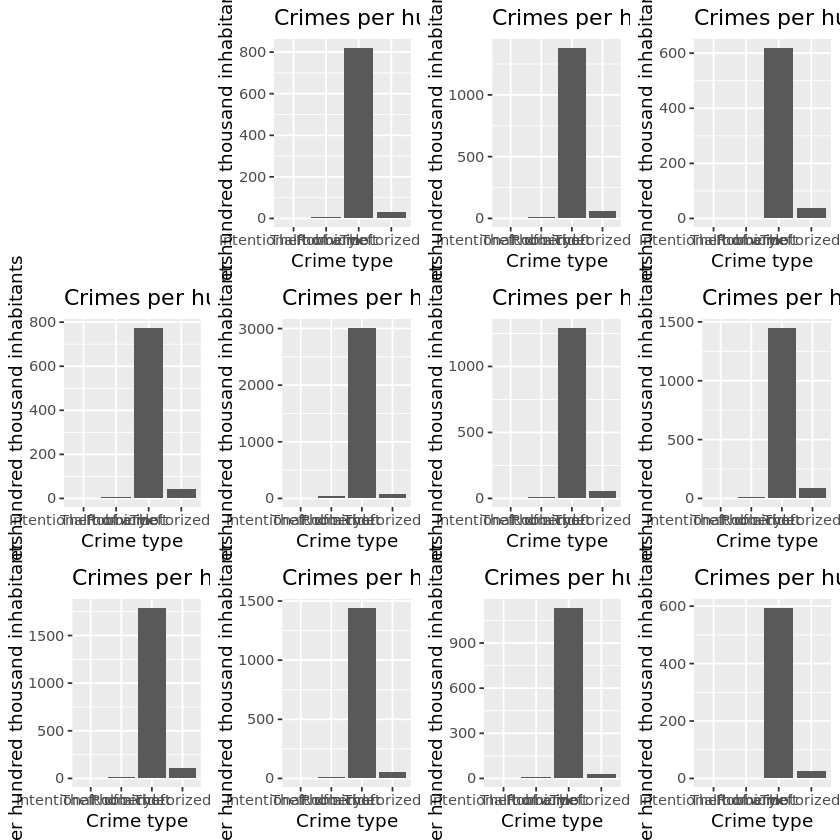

In [159]:
# Get all Norway NUTS3 region codes
norway_nuts3_regions = unique(data$geo)

# Prepare a function which plots a bar plot for each region
region_bar_plot <- function(region){
    # Select data by the region
    data_region = data[data$geo == region,]
    # Make a single bar plot
    plot <- ggplot( data = data_region, mapping = aes(x = iccs, y= values)) +
           geom_bar(stat="identity") +   # stat="identity" allows us to use y = values
           labs(title = paste("Crimes per hundred thousand inhabitants in ", region), x = "Crime type", y = "Per hundred thousand inhabitants")
    return(plot)
}

plots <- list()
for ( region in norway_nuts3_regions ) {
  # Create the plot
  region_plot <- region_bar_plot(region)
  # Add the plot to the list
  plots <- c(plots, list(region_plot))
}

final_plot <- plot_grid(plotlist = plots, ncols = 4)
final_plot

In [160]:
...

ERROR: Error in eval(expr, envir, enclos): '...' used in an incorrect context


## Contingency table

## Hypotheses and tests